In [11]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from derivative import derivatives_2d
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
from scipy.interpolate import RegularGridInterpolator, CubicSpline
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [86]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
γ3_list = np.array([0, 0.0197*2, 1/3])
# γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [218]:
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

# y_step = 0.05
# y_grid = np.arange(0., 4 + y_step, y_step)

k_step = 0.1
k_grid = np.arange(0., 9 + k_step, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [219]:
y_mat.shape

(101, 91)

In [220]:
def solve_new(y_grid, k_grid, args, ϵ=0.5, max_iter=2000, tol=1e-6):
    δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]
    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    
    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
    ddΛ = γ2 + γ3*(y_mat > y_bar)
    v0 =  -  η*y_mat**2 + k_mat**2
    ems_new = η*y_mat**2 + k_mat**2
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    vd = - 1/δ
    while lhs_error > tol:
        if episode ==0:
            i = 0
            ems = ems_new
            mc_new = 1/(α - i - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems/np.exp(k_mat))**θ) )
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,dy)
        v0_dyy = derivatives_2d(v0,0,2,dy)
        v0_dk = derivatives_2d(v0,1,1,dk)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
        v0_dkk = derivatives_2d(v0,1,2,dk)
        # updating controls
        mc = mc_new
        i_new = 1 - mc/v0_dk
        # update emission
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*np.exp(ϑ_bar)*np.exp(2*(λ_bar-k_mat))
        b = mc*θ*np.exp(ϑ_bar + λ_bar - k_mat) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = -b/a
        ems_new[ems_new < 1e-15] = 1e-15
        mc_new = 1/(α - i_new - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat))**θ) )
#         ems_new[ems_new <= 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5

#         weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
#         weight = weight - np.max(weight, axis=0)
#         πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
#         πa = πa/np.sum(πa, axis=0)
        print(np.min(ems_new))
        # HJB coefficient
        entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        A =  -δ*np.ones(y_mat.shape)
        B_y = np.sum(θ_mat*πa, axis=0)*ems
        B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
        C_yy = 0.5*ems**2*σy**2
        C_kk = 0.5*σk**2*np.ones(y_mat.shape)
        D = np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
            + ξa*entropy
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems_new
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

$$
mc = \frac{1}{\alpha - i - \alpha \vartheta (1 - \frac{e}{\alpha \lambda  \exp(k)})^\theta}
$$

First order condition for $i$:

$$
 - mc + \frac{d\phi}{dk} (1 - \kappa i) = 0
$$

FOC for $e$:

$$
mc (\bar{\vartheta} \theta \frac{1 }{\lambda \exp (k)}  (1 - \frac{e}{\alpha \lambda \exp{k}})^{\theta - 1}) + 
$$

In [235]:
# HJB for ϕ_m
# θ = 2
θ = 3
y_bar = 2
ξa = 0.01
# ξa = 10000
# ξb = 3
ξb = 10000
λ_bar = 0.134
# λ_bar = 0.102
# λ_bar = 0.0925
# ϑ_bar = 0.078
# ϑ_bar = 0.054
# ϑ_bar = 0.048

ϑ_bar = 0.052
# ϑ_bar = 0.036
# ϑ_bar = 0.032

# γ3 = γ3_list[1]*3.0
γ3 = γ3_list[2]

α=0.115

# ϵ=2.5
ϵ=0.1


max_iter=2000
tol=1e-7

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

# dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
dΛ = γ1 + γ2*y_mat + γ3*(y_mat-ȳ)*(y_mat>ȳ)
# ddΛ = γ2 + γ3*(y_mat > y_bar)
ddΛ = γ2 + γ3*(y_mat>ȳ)

    
# initial guess
v0 =  (1/δ)*k_mat  -  η/δ*y_mat**2 
# initial i
a_i = κ*(1/δ)
b_i = - (1 + α*κ)*(1/δ)
c_i = α*(1/δ) - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)

ems = η*np.ones(y_mat.shape)
mc = 1/(α - i - α*ϑ_bar*(1 - ems/(np.exp(k_mat)*α*λ_bar))**θ )

episode = 0
lhs_error = 0.5
vd = - 1/δ

while lhs_error > tol:
    vold = v0.copy()
    v0_dy = derivatives_2d(v0,0,1,dy)
    v0_dyy = derivatives_2d(v0,0,2,dy)
    v0_dk = derivatives_2d(v0,1,1,dk)
    v0_dk[v0_dk < 1e-15] =  1e-15
    v0_dkk = derivatives_2d(v0,1,2,dk)
    # updating controls
    i_new = (1 -mc/v0_dk)*(1/κ)
#     update emission
    if θ == 2:
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        b = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = -b/a
        ems_new = (ems_new)*(ems_new>0)
    elif θ == 3:
        b = v0_dyy*σy**2 + vd*ddΛ*σy**2 - 2*mc*θ*ϑ_bar/(α*λ_bar**2*np.exp(2*k_mat))
        c = mc*θ*ϑ_bar/(λ_bar*np.exp(k_mat)) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        a = mc*θ*ϑ_bar/(α**2*λ_bar**3*np.exp(3*k_mat))    
        ems_new =  (-b-np.sqrt(b**2 - 4*a*c))/(2*a)
#         ems_new = (ems_new)*(ems_new>0)

    i_new = i_new*0.05 + i*0.95
    ems_new = ems_new*0.05 + ems*0.95
    ratio = (1 - ems_new/(α*λ_bar*np.exp(k_mat)))*( (1 - ems_new/(α*λ_bar*np.exp(k_mat))) > 0 )
    consumption = α - i_new - α*ϑ_bar*ratio**θ
#     consumption[c# mc[mc < 1e-15] = 1e-1510onsumption <= 1e-15] = 1e-15
    mc_new = 1/consumption
    
#     mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.05 + mc*0.95
    temp = v0_dy + vd*dΛ
    weight = np.array([-1/ξa*temp*ems_new*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    print("min ems:", np.min(ems_new))
    print("min mc", np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = - np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
    mc = mc_new
    i = i_new

min ems: -17.124352353849268
min mc 39.99791726530605
Episode 0: PDE Error: 1.948494489228; False Transient Error: 1.947117752121; Iterations: 5; CG Error: 0.000000000086
min ems: -26.126484008236076
min mc 39.99791014326011
Episode 1: PDE Error: 1.939982854795; False Transient Error: 1.938746337090; Iterations: 8; CG Error: 0.000000000031
min ems: -34.52663045501587
min mc 39.997901877955464
Episode 2: PDE Error: 1.934524771844; False Transient Error: 1.933454193330; Iterations: 10; CG Error: 0.000000000059
min ems: -42.335193188707024
min mc 39.99789154730988
Episode 3: PDE Error: 2.036876009295; False Transient Error: 2.029541187404; Iterations: 13; CG Error: 0.000000000036
min ems: -49.57483394363906
min mc 39.99787842343965
Episode 4: PDE Error: 2.551173639821; False Transient Error: 2.540086915337; Iterations: 15; CG Error: 0.000000000082
min ems: -56.27671968043794
min mc 39.997861938682654
Episode 5: PDE Error: 3.002458830277; False Transient Error: 2.987434758759; Iterations: 

min ems: -132.7736075796269
min mc 39.96388880326763
Episode 48: PDE Error: 3.942666892012; False Transient Error: 3.884607971859; Iterations: 88; CG Error: 0.000000000098
min ems: -132.688273751547
min mc 39.96463037652201
Episode 49: PDE Error: 3.884721383223; False Transient Error: 3.827280344921; Iterations: 89; CG Error: 0.000000000077
min ems: -132.57776447583404
min mc 39.96517903972083
Episode 50: PDE Error: 3.827473198877; False Transient Error: 3.770655580282; Iterations: 88; CG Error: 0.000000000091
min ems: -132.44369695280588
min mc 39.96558881155509
Episode 51: PDE Error: 3.770941833234; False Transient Error: 3.714750289269; Iterations: 88; CG Error: 0.000000000083
min ems: -132.28759344228752
min mc 39.96586736263722
Episode 52: PDE Error: 3.715140201193; False Transient Error: 3.659576532380; Iterations: 88; CG Error: 0.000000000080
min ems: -132.11088781808937
min mc 39.9660657138854
Episode 53: PDE Error: 3.660077453674; False Transient Error: 3.605142405472; Iterati

min ems: -98.7188937187067
min mc 39.88066198756683
Episode 144: PDE Error: 1.677564747677; False Transient Error: 1.676969444585; Iterations: 43; CG Error: 0.000000000065
min ems: -98.39321305580535
min mc 39.878929564368455
Episode 145: PDE Error: 1.675969020968; False Transient Error: 1.675325936756; Iterations: 42; CG Error: 0.000000000092
min ems: -98.06930029934546
min mc 39.87719515852355
Episode 146: PDE Error: 1.674373419500; False Transient Error: 1.673682875274; Iterations: 42; CG Error: 0.000000000082
min ems: -97.74714383022643
min mc 39.87545877403199
Episode 147: PDE Error: 1.672777935215; False Transient Error: 1.672040735524; Iterations: 42; CG Error: 0.000000000073
min ems: -97.4267332245157
min mc 39.87372041484008
Episode 148: PDE Error: 1.671182592337; False Transient Error: 1.670400141907; Iterations: 41; CG Error: 0.000000000098
min ems: -97.1080629149471
min mc 39.871980085185015
Episode 149: PDE Error: 1.669587490482; False Transient Error: 1.668759711415; Iter

Episode 192: PDE Error: 1.601406129343; False Transient Error: 1.599834716568; Iterations: 32; CG Error: 0.000000000072
min ems: -84.64897873942621
min mc 39.785960522665995
Episode 193: PDE Error: 1.599834669717; False Transient Error: 1.598264095916; Iterations: 32; CG Error: 0.000000000067
min ems: -84.39793173786475
min mc 39.78390173489406
Episode 194: PDE Error: 1.598264007528; False Transient Error: 1.596693174916; Iterations: 31; CG Error: 0.000000000096
min ems: -84.14818077207659
min mc 39.781841739131025
Episode 195: PDE Error: 1.596694212875; False Transient Error: 1.595124288555; Iterations: 31; CG Error: 0.000000000088
min ems: -83.89971404770549
min mc 39.77978054889853
Episode 196: PDE Error: 1.595125226168; False Transient Error: 1.593556215042; Iterations: 31; CG Error: 0.000000000080
min ems: -83.65252261672019
min mc 39.777718177851845
Episode 197: PDE Error: 1.593557057172; False Transient Error: 1.591988979220; Iterations: 31; CG Error: 0.000000000074
min ems: -83

min ems: -74.13730282209126
min mc 39.68690613738015
Episode 240: PDE Error: 1.527003346661; False Transient Error: 1.525477620896; Iterations: 26; CG Error: 0.000000000059
min ems: -73.94003897060124
min mc 39.68473667166973
Episode 241: PDE Error: 1.525477937778; False Transient Error: 1.523953350883; Iterations: 26; CG Error: 0.000000000056
min ems: -73.74379149547387
min mc 39.68256735422374
Episode 242: PDE Error: 1.523953620357; False Transient Error: 1.522431203017; Iterations: 25; CG Error: 0.000000000094
min ems: -73.54855908221171
min mc 39.68039820575177
Episode 243: PDE Error: 1.522430344310; False Transient Error: 1.520909020149; Iterations: 25; CG Error: 0.000000000089
min ems: -73.35433526632258
min mc 39.67822924734194
Episode 244: PDE Error: 1.520908178061; False Transient Error: 1.519387950422; Iterations: 25; CG Error: 0.000000000083
min ems: -73.1611149312792
min mc 39.676060500125324
Episode 245: PDE Error: 1.519387124407; False Transient Error: 1.517867997001; Ite

Episode 289: PDE Error: 1.453620715405; False Transient Error: 1.452153590154; Iterations: 22; CG Error: 0.000000000051
min ems: -65.44243379401905
min mc 39.5790341387775
Episode 290: PDE Error: 1.452153675927; False Transient Error: 1.450687864743; Iterations: 22; CG Error: 0.000000000049
min ems: -65.29132144154191
min mc 39.5768984419098
Episode 291: PDE Error: 1.450687915791; False Transient Error: 1.449223420301; Iterations: 22; CG Error: 0.000000000046
min ems: -65.14104532851695
min mc 39.574763976208494
Episode 292: PDE Error: 1.449223437813; False Transient Error: 1.447760864853; Iterations: 21; CG Error: 0.000000000098
min ems: -64.99161332830063
min mc 39.57263076355667
Episode 293: PDE Error: 1.447760228500; False Transient Error: 1.446298963830; Iterations: 21; CG Error: 0.000000000093
min ems: -64.84301417506452
min mc 39.57049882573347
Episode 294: PDE Error: 1.446298305556; False Transient Error: 1.444838349579; Iterations: 21; CG Error: 0.000000000089
min ems: -64.695

min ems: -59.08004369233989
min mc 39.478282057812095
Episode 338: PDE Error: 1.383274641022; False Transient Error: 1.381872881618; Iterations: 19; CG Error: 0.000000000060
min ems: -58.96569757550359
min mc 39.47622960378674
Episode 339: PDE Error: 1.381872076516; False Transient Error: 1.380471624045; Iterations: 19; CG Error: 0.000000000058
min ems: -58.852046689038396
min mc 39.47417939339814
Episode 340: PDE Error: 1.380470826970; False Transient Error: 1.379071680281; Iterations: 19; CG Error: 0.000000000056
min ems: -58.73908827914882
min mc 39.47213144659269
Episode 341: PDE Error: 1.379070890765; False Transient Error: 1.377673048604; Iterations: 19; CG Error: 0.000000000053
min ems: -58.62681958933615
min mc 39.470085783254
Episode 342: PDE Error: 1.377672266207; False Transient Error: 1.376275727238; Iterations: 19; CG Error: 0.000000000051
min ems: -58.51523786129091
min mc 39.46804242320222
Episode 343: PDE Error: 1.376274951520; False Transient Error: 1.374879714289; Ite

<ipython-input-235-73f0e5946306>:87: RuntimeWarning: invalid value encountered in sqrt
  ems_new =  (-b-np.sqrt(b**2 - 4*a*c))/(2*a)


Episode 377: PDE Error: nan; False Transient Error: nan; Iterations: 18382; CG Error: nan


(array([0.05555556, 0.08333333, 0.13194444, 0.13888889, 0.11805556,
        0.20138889, 0.10416667, 0.07638889, 0.0625    , 0.02777778]),
 array([1.0154  , 1.194787, 1.374174, 1.553561, 1.732948, 1.912335,
        2.091722, 2.271109, 2.450496, 2.629883, 2.80927 ]),
 <BarContainer object of 10 artists>)

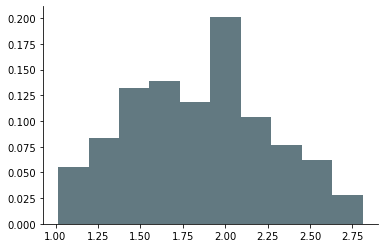

In [222]:
plt.hist(θ_list*1000, weights=πa[:,-1,-1])
plt.hist(θ_list*1000, weights=πa_o[:, 0, 0], alpha=0.3)

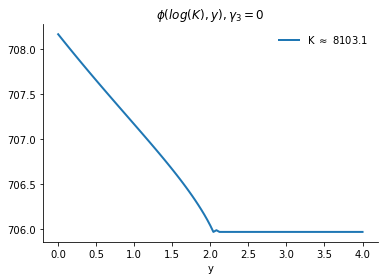

In [223]:
loc1 = np.abs(np.exp(k_grid) - 700).argmin()
# plt.plot(y_grid, v0[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
# plt.plot(y_grid, v0[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.plot(y_grid, v0[:, -1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[-1])))
plt.legend()
plt.title(r'$\phi(log(K), y), \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ϕ_new.png', dpi=300)
plt.show()

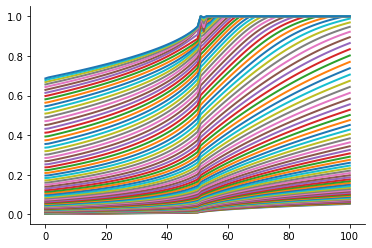

In [224]:
plt.plot(1 -  ems_new/(α*λ_bar*np.exp(k_mat)))
plt.show()

Text(0.5, 0, 'y')

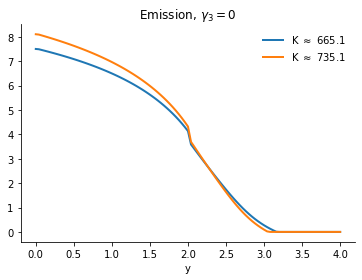

In [225]:
# plt.plot(y_grid, ems[:, -1])
plt.plot(y_grid, ems[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ems[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'Emission, $\gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('emission_01.png', dpi=300)
# plt.ylim(0,12)

In [226]:
y_grid[-50], y_mat.shape

(2.04, (101, 91))

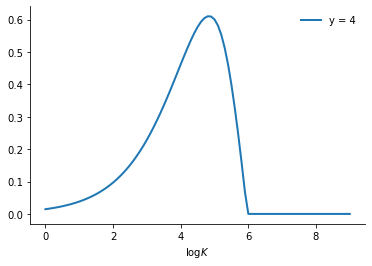

In [227]:
plt.plot(k_grid, ems[-1], label="y = 4")
plt.xlabel("$\log K$")
plt.legend()
plt.savefig('e_logk.png')

In [228]:
np.exp(7), y_grid[40]

(1096.6331584284585, 1.6)

Text(0.5, 1.0, 'Emission')

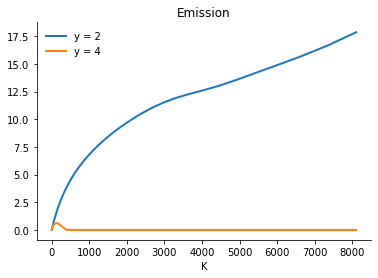

In [229]:
plt.plot(np.exp(k_grid), ems[40], label = "y = 2")
plt.plot(np.exp(k_grid), ems[-1], label = "y = 4")
plt.legend()
plt.xlabel('K')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 1.0, 'Emission')

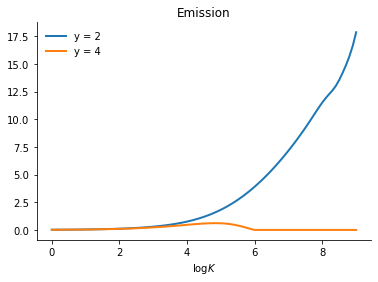

In [230]:
plt.plot(k_grid, ems[40], label = "y = 2")
plt.plot(k_grid, ems[-1], label = "y = 4")
plt.legend()
plt.xlabel('$\log K$')
plt.title('Emission')
# plt.savefig('emission_k_9.png', dpi=300)

Text(0.5, 0, 'y')

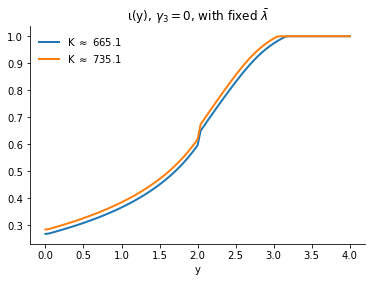

In [231]:
iota = 1 - ems/np.exp(k_mat)/α/λ_bar
plt.plot(y_grid, iota[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, iota[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'ι(y), $\gamma_3 = 0$, with fixed $\bar \lambda$')
plt.xlabel('y')
# plt.savefig('iota_01.png', dpi=300)

Text(0.5, 0, 'y')

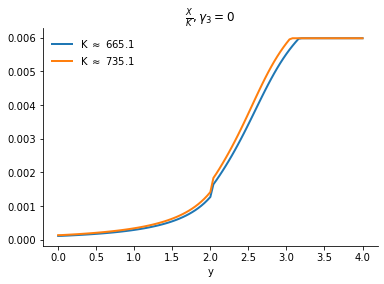

In [232]:
ra = α*ϑ_bar*iota**θ
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{X}{K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('XK_new.png', dpi=300)

Text(0.5, 0, 'y')

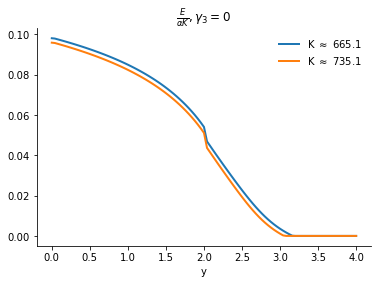

In [233]:
ra = ems/np.exp(k_mat)/α
plt.plot(y_grid, ra[:, loc1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1])))
plt.plot(y_grid, ra[:, loc1+1], label=r"K $\approx$ {:.1f}".format(np.exp(k_grid[loc1+1])))
plt.legend()
plt.title(r'$\frac{E}{\alpha K}, \gamma_3 = 0$')
plt.xlabel('y')
# plt.savefig('ratio_01.png', dpi=300)

In [234]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [202]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Simulation

??:

$$
ME_t = \vartheta_t \theta \frac{1}{\lambda_t} \left[1 -  \frac{\mathcal{E}_t}{\alpha \lambda_t K_t }\right]^{\theta - 1}
$$

In [203]:
class GridInterp_2d():

    def __init__(self, grids, values, method = 'Linear'):

        # unpacking
        self.grids = grids
        (self.xs, self.ys) = grids
        self.nx = len(self.xs)
        self.ny = len(self.ys)
        
        self.values = values

        assert (self.nx, self.ny) == values.shape, "ValueError: Dimensions not match"
        self.method = method

    def get_value(self, x, y):

        if self.method == 'Linear':
            
            func = RegularGridInterpolator(self.grids, self.values)
            return func([x,y])[0]

        elif self.method == 'Spline':

            func1 = CubicSpline(self.xs, self.values)
            ySpace = func1(x)
            
            func2 = CubicSpline(self.ys, ySpace)
            return func2(y)

        else:
            raise ValueError('Method Not Supported')

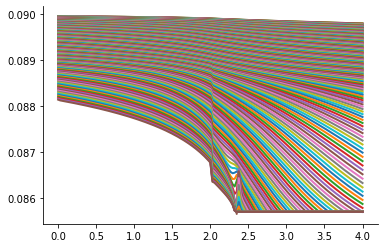

In [204]:
plt.plot(y_grid, i)
plt.show()

In [205]:
Time = 90
ppy = 12
pers = ppy * Time
# pers = 100
dt = Time / pers
nDims = 3 
its = 1

gridpoints = (y_grid, k_grid)
# interpolate emission
e_func_r = GridInterp_2d(gridpoints, ems, 'Linear')
def e_func(x):
    return e_func_r.get_value(x[0], x[1]) # match order
# interpolate investment
i_func_r = GridInterp_2d(gridpoints, i, 'Linear')
def i_func(x):
    return i_func_r.get_value(x[0], x[1])

# drifts for each diffusion process
def compute_μlogk(x):
    return μk +  i_func(x)  - 0.5*κ*i_func(x)**2 - 0.5*σk**2
def compute_μy(E_x):
    return  E_x*np.mean(θ_list)
def compute_μlogd(x, E_x):
    Y_x = x[0]
    dΛ = γ1 + γ2*Y_x + γ3*(Y_x - y_bar)*(Y_x >y_bar)
    ddΛ = γ2 + γ3*(Y_x > y_bar)  
    return dΛ*compute_μy(E_x) + 0.5*ddΛ*σy**2*E_x**2

# initial points

K_0 = 80/α
Y_0 = 1.1
D_0 = np.exp(γ1*Y_0 + γ2*Y_0**2 + γ3*((Y_0 - y_bar)**2)*(Y_0 >y_bar))-1
          
# stop
hist = np.zeros([pers, nDims])
e_hist = np.zeros([pers])
i_hist = np.zeros([pers])

for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [Y_0, np.log(K_0), D_0]
        e_hist[0] = e_func(hist[0,:])
        i_hist[0] = i_func(hist[0,:])

    else:
        # other periods
        hist[tm,0] = hist[tm - 1,0] + compute_μy(e_hist[tm-1])*dt# Y
        hist[tm,1] = hist[tm - 1,1] + compute_μlogk(hist[tm-1,:])*dt# logK
        hist[tm,2] = hist[tm - 1,2] + compute_μlogd(hist[tm-1,:], e_hist[tm-1])*dt # logDt
        e_hist[tm] = e_func(hist[tm,:])
        i_hist[tm] = i_func(hist[tm,:])

e_k_ratio = e_hist/np.exp(hist[:,1])/α
Iota_t = 1 - e_hist/np.exp(hist[:,1])/(α*λ_bar)
XK_t = α*θ_bar*Iota_t**θ
MUe = θ*θ_bar/λ_bar*Iota_t**(θ-1)

simul = dict(e= e_hist, states= hist)

In [206]:
1/3

0.3333333333333333

Text(0.5, 0, 'Years')

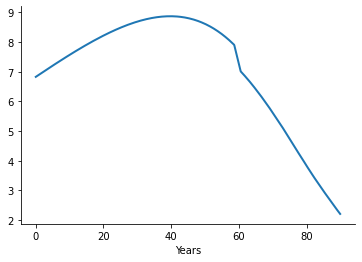

In [207]:
plt.plot(np.arange(0, Time, dt), e_hist)
plt.xlabel('Years')
# plt.savefig('Et.png')

Text(0.5, 1.0, '$\\frac{E_t}{\\alpha K_t}$')

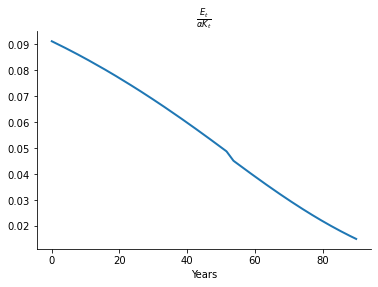

In [121]:
plt.plot(np.arange(0, Time, dt), e_k_ratio)
plt.xlabel('Years')
plt.title(r'$\frac{E_t}{\alpha K_t}$')
# plt.savefig('ratio.png')

Text(0.5, 1.0, '$\\iota_t$')

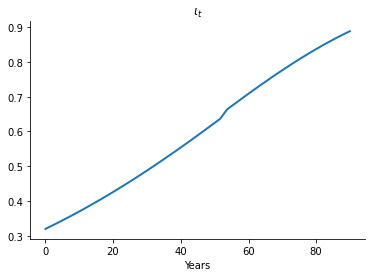

In [122]:
plt.plot(np.arange(0, Time, dt), Iota_t)
plt.xlabel('Years')
plt.title(r"$\iota_t$")
# plt.savefig('iota_t.png')

In [123]:
hist[480],e_hist[480]

(array([1.77112699, 7.32389031, 0.00992543]), 10.417991891849548)

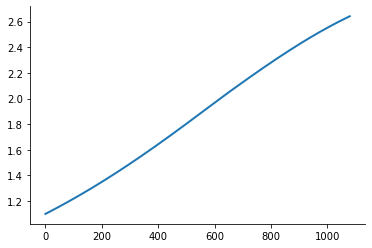

In [124]:
plt.plot(hist[:,0])

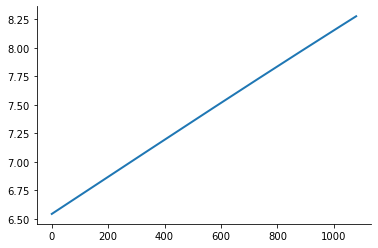

In [125]:
plt.plot(simul['states'][:, 1])

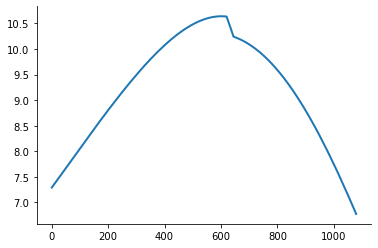

In [126]:
plt.plot(simul['e'])